# KBS recognition

In [73]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import imutils
import os
from PIL import Image
from typing import Union, Tuple
import uuid
from tensorflow import keras

In [78]:
def find_table(path):
    img = cv.imread(f"{path}")
#     img = cv.resize(img, (851, img.shape[0]))
#     cv.imwrite("pic.jpg", img)
    gr = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    canny = cv.Canny(gr, 10, 250)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
    closed = cv.morphologyEx(canny, cv.MORPH_CLOSE, kernel)
    contours = cv.findContours(closed.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
    contours = sorted(contours, key = cv.contourArea, reverse = True)[:1]
    for cont in contours:
            #сглаживание и определение количества углов
            sm = cv.arcLength(cont, True)
            apd = cv.approxPolyDP(cont, 0.02*sm, True)
            #выделение контуров
            if len(apd) == 4:
#                 cv.drawContours(img, [apd], -1, (0,255,0), 4)
                height, width = gr.shape
                minarea = (height * width) * 0.20

                th_level = 255 - (255 - np.median(gr)) * 0.98
                (th_level, thresholded) = cv.threshold(gr, thresh=th_level, maxval=255, type=cv.THRESH_BINARY)
                (contours, hierarchy) = cv.findContours(thresholded, mode=cv.RETR_LIST, method=cv.CHAIN_APPROX_SIMPLE)

                bbox = cv.minAreaRect(apd)
                (bcenter, bsize, bangle) = bbox
                bcenter = np.array(bcenter)
                bsize = np.array(bsize)
                (rot90, bangle) = divmod(bangle + 45, 90)
                bangle -= 45
                if rot90 % 2 != 0:
                    bsize = bsize[::-1]

                # construct affine transformation
                M1 = np.eye(3)
                M1[0:2,2] = -bcenter

                R = np.eye(3)
                R[0:2] = cv.getRotationMatrix2D(center=(0,0), angle=bangle, scale=1.0)

                M2 = np.eye(3)
                M2[0:2,2] = +bsize * 0.5

                M = M2 @ R @ M1

                bwidth, bheight = np.ceil(bsize)
                dsize = (int(bwidth), int(bheight))

                out = cv.warpAffine(img, M[0:2], dsize=dsize, flags=cv.INTER_CUBIC) 
    # необходимо обрабатывать размеры, так как размер шапки изменяется
    out = cv.resize(out, (1383, int(bheight)))
    cv.imwrite(f'output_1.jpg', out)
    return out

In [76]:
# document = find_table("../test-ci/pics/kpi_123683_1.jpg")
document = find_table("../kpi_118815_4.jpg")

In [44]:
def test_dun(first_column, second_column):
    size1 = first_column.shape
    size2 = second_column.shape
    background = Image.new('RGB', (400, 60+size2[0]), (255, 255, 255))

    img = Image.fromarray(first_column)
    offset = 47, 0 # 31
    background.paste(img, offset)

    img1 = Image.fromarray(second_column)
    offset = 190, 0

    background.paste(img1, offset)
    background.save('background.jpg')

In [5]:
def rows_test(im: np.ndarray, weight_list: Union[float, int]) -> dict:
    """
    Функция ищет горизонтальные линии - строки, обрезает по строкам изображение.
    :param im изображение, которое нужно разрезать построчно
    :param path путь куда нужно сохранить части изображения
    :param list_name имя файла, котоорому принадлежат части изображения
    :param key_word ключевое слово в названии части изображения (нужно для сохранения)
    :param weight_list ширина изображения, которого нужно обрезать
    """
    a = 1
    # IMREAD_GRAYSCALE обязательный параметр при считывании, без него нельзя работать с шумами изобр.

    # Запись в бд
    # first = Db_kpi(filename=name)
    # first.save()

    original = np.copy(im)  # сохранение оригинала
    gray_image = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    (thresh, img_bin) = cv.threshold(
        gray_image, 190, 255, cv.THRESH_BINARY | cv.THRESH_OTSU
    )  # создание шума
    img_bin = 255 - img_bin
    # длина ядра изобр, последнее число примерная ширина изобр. в пикселях
    kernel_length = np.array(im).shape[1] // weight_list
    # обнаружение гориз. линий
    horizontal_kernel = cv.getStructuringElement(
        cv.MORPH_RECT, (kernel_length, 1)
    )
    img_temp2 = cv.erode(img_bin, horizontal_kernel, iterations=3)
    horizontal_lines_img = cv.dilate(
        img_temp2, horizontal_kernel, iterations=3
    )
    edges = cv.Laplacian(horizontal_lines_img, cv.CV_8U)
    # ядро используется для удалении вертик. линий и коротких гориз. линий
    kernel1 = np.zeros((6, 32), np.uint8)
    kernel1[2, :] = 1
    # eroded = cv.morphologyEx(edges, cv.MORPH_ERODE, kernel1)
    eroded = cv.morphologyEx(edges, cv.MORPH_OPEN, kernel1)
#     cv.imwrite("doc.jpg", eroded)

    indices = np.nonzero(eroded)  # координаты гориз. линий
    rows = np.unique(indices[0])  # координата y

    filtered_rows = []
    data = {}
    for ii in range(len(rows)):
        if ii == 0:
            filtered_rows.append(rows[ii])
        else:
            if np.abs(rows[ii] - rows[ii - 1]) >= 5:
                filtered_rows.append(rows[ii])

    # вырезание строк
    try:
        for i in np.arange(len(filtered_rows) - 1):
            ima = original[filtered_rows[i]: filtered_rows[i + 1]]
            data[f"{i}"] = ima
#             cv.imwrite(f'changed_pic_{i}.jpg', ima)
            # data.update(recognition_bonus(image=ima,
            #                               type_list=document_class, birthplace=first))

            a += 1

    except IndexError as e:
        e
    return data

In [46]:
def kbs_recognition(table: np.ndarray):
    data_of_table = rows_test(im=table, weight_list=table.shape[1])
    num_dict = {}
    bonus_dict = {}

    # размер листа для записи
    hgt = data_of_table[f"{1}"].shape[0] * len(data_of_table) + 100
    background = Image.new('RGB', (150, hgt), (255, 255, 255))
    indent = 0
    for i in range(len(data_of_table)):
        doc = data_of_table[f'{i}']
        num_col = doc[0:doc.shape[0], 47:187]
        bonus_col = doc[0:doc.shape[0], 188:308]
        # словарь с номерами
        num_dict[i] = doc[0:doc.shape[0], 47:187]
        # словарь с подписями
        bonus_dict[i] = doc[0:doc.shape[0], 188:308]

        # вывод для проверки разрезки
        cv.imwrite(f'cropped_num_{i}.jpg', num_col)
        num = uuid.uuid4()
        cv.imwrite(f'bonuses/cropped_sign_{num}.jpg', bonus_col)

        size = bonus_col.shape[0]
        img = Image.fromarray(bonus_col)
        if i == 0:
            offset = 15, 0
        else:
            # добавляем отступ
            indent += size + 5
            offset = 15, indent
        background.paste(img, offset)

    background.save('background_new.jpg')
    # print(num_dict, 'num dict')
    # распознавание номеров
    numbers = {}
#     for i in range(len(num_dict)):
#         numbers[number_recognition(num_dict[i])] = {
#             "bonus": True,
#             "confidence": True
#         }
    return numbers

In [77]:
# first_column = document[65:document.shape[0], 38:110]
# second_column = document[65:document.shape[0], 690:790]
first_column = document[80:document.shape[0], 60:200]
second_column = document[80:document.shape[0], 1015:1152]
test_dun(first_column, second_column)
table_pic = cv.imread('background.jpg')
data1 = kbs_recognition(table_pic)

In [ ]:
# def number_recognition(image: np.ndarray) -> int:
#     custom_config = r'--oem 3 --psm 6'
#     im = pytesseract.image_to_string(image, config=custom_config)
#     # number = im
#     number = int(re.findall('\d+', im)[0])
#     return number

2022-07-21 10:23:20.489579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 167ms/step
The prediction is  [[1.]]


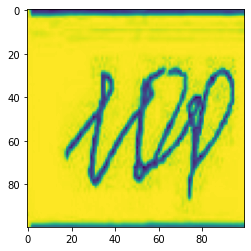

In [74]:
model = keras.models.load_model('bonuses_model.h5')
image = cv.imread("bonuses/cropped_sign_9d6f658e-7442-4d91-8572-603cdcf2b55a.jpg")
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (100, 100))
plt.imshow(image)
input_img = np.expand_dims(image, axis=0)
print("The prediction is ", model.predict(input_img))